# Working with Data - Computer Lab for Guest Lecture Julia Lane

In this computer lab we will learn more more details and practice data work to enhance the content of the lecture presented by Julia Lane on responsible data use. We will address a research question, think about data and measurement errors, and manipulate data. 

OUTLINE: 
1. Define a research question 
2. Think about what data are available 
3. Think about possible measurement errors 
4. Think about the interpretation of your results 
5. Inform your results by linking datasets 

# 1. Define a reserach question
Which Community Districts in NYC show the highest number of complaints?

# 2. Think about what data are available
Find suitable data by searching the CUSP Data Catalog https://datahub.cusp.nyu.edu/catalog. You can use Urban Profiler to investigate the Metadata associated with each dataset. Using this tool will help you to decide which attributes of the data you need to answer your question so you don't have to load the entire dataset. 

In [1]:
import os
import pandas as pd
import numpy as np
import re
PUIdata = os.getenv('PUIDATA')

In [31]:
# Load dataset
url = '/projects/open/NYCOpenData/nycopendata/data/erm2-nwe9/1446832678/erm2-nwe9'
cols = ['Agency Name', 'Borough', 'Complaint Type', 'Community Board', 'Descriptor', 'Resolution Description']
data = pd.read_csv(url, usecols=cols)
data.head()

,Agency Name,Complaint Type,Descriptor,Resolution Description,Community Board,Borough
0,Department of Transportation,Street Condition,Pothole,NaN,13 BROOKLYN,BROOKLYN
1,CHALL,Opinion for the Mayor,HOUSING,Your comments have been submitted to the Mayor...,0 Unspecified,Unspecified
2,Department of Parks and Recreation,Root/Sewer/Sidewalk Condition,Trees and Sidewalks Program,The Department of Parks and Recreation usually...,18 BROOKLYN,BROOKLYN
3,New York City Police Department,Illegal Parking,Blocked Hydrant,Your complaint has been received by the Police...,12 BROOKLYN,BROOKLYN
4,HRA Benefit Card Replacement,Benefit Card Replacement,Medicaid,The Human Resources Administration received yo...,0 Unspecified,Unspecified


# 3. Think about possible measurement errors
Do you see any problems regarding possible measurement error? Think about who is represented in the data, ommissions, duplications, content error, missing data, etc. 

In [7]:
# Check if all Boroughs and Community Districts are represented in the Data 
data['Borough'].unique()

array(['BROOKLYN', 'Unspecified', 'STATEN ISLAND', 'MANHATTAN', 'BRONX',
       'QUEENS'], dtype=object)

In [8]:
# How many unique values do we have? 
len(data['Community Board'].unique())

77

In [32]:
# Why do we have so many? Some of them are unspecified, missing. Some might be invalid entries. 
# We should have 59 Community Districts.
CDs = data['Community Board'].unique()
CDs

array(['13 BROOKLYN', '0 Unspecified', '18 BROOKLYN', '12 BROOKLYN',
       '02 STATEN ISLAND', '08 MANHATTAN', '06 BROOKLYN', '10 BRONX',
       '06 MANHATTAN', '04 BROOKLYN', '04 QUEENS', '09 MANHATTAN',
       '14 BROOKLYN', '05 MANHATTAN', '02 MANHATTAN', '10 QUEENS',
       '07 QUEENS', '02 QUEENS', '11 BROOKLYN', '05 QUEENS', '05 BROOKLYN',
       '09 QUEENS', '12 MANHATTAN', '01 BROOKLYN', '11 MANHATTAN',
       '03 BRONX', '03 STATEN ISLAND', '08 BROOKLYN', '03 BROOKLYN',
       '07 MANHATTAN', '10 MANHATTAN', '04 BRONX', '01 MANHATTAN',
       '07 BRONX', '09 BRONX', '03 MANHATTAN', '13 QUEENS', '02 BRONX',
       '12 QUEENS', '16 BROOKLYN', '08 QUEENS', '04 MANHATTAN',
       '14 QUEENS', '10 BROOKLYN', '11 QUEENS', '06 BRONX', '08 BRONX',
       '05 BRONX', '15 BROOKLYN', '02 BROOKLYN', '12 BRONX', '03 QUEENS',
       '06 QUEENS', '01 STATEN ISLAND', '01 BRONX', '01 QUEENS',
       '17 BROOKLYN', '11 BRONX', 'Unspecified QUEENS', '09 BROOKLYN',
       'Unspecified MANHATTAN'

In [107]:
# Generate marker for unplausible Community Districts
# How do these districts look like? 

# Drop the marked districts

def contain(string):
    flag = True
    if 'Unspecified' in string:
        flag = False
    elif int(string[:2]) > 20:
        flag = False
    return flag
Contain = np.vectorize(contain)

Quick look the unique values. We can find all the Community Boards of New York [here](http://www.nyc.gov/html/cau/html/cb/cb.shtml). We know the number of these communities are **no more than 20**. Thus, we can drop values that contain **'Unspecified'** and the number that **more than 20**.

In [53]:
TCDs = CDs[Contain(CDs)]
len(TCDs)

59

In [56]:
def contain_values(string):
    return string in TCDs
Contain_V = np.vectorize(contain_values)

In [65]:
data1 = data.iloc[Contain_V(data['Community Board'].values)]

In [70]:
len(data1)

8110945

In [75]:
# Check for duplicates? Are these plausible?
data2 = data1.drop_duplicates()

In [76]:
len(data2)

179488

In [86]:
# What about missing values? Can you detect any patterns? 
data2.isnull().sum()

Agency Name                   0
Complaint Type                0
Descriptor                 3525
Resolution Description    34588
Community Board               0
Borough                       0
dtype: int64

There are **3525** missing values of **'Descriptor'** and **34588** missing values of **'Resolution Description'**.

In [106]:
# Data Editing: Is it possible to replace missing values? Is it possible to use Complaint Type 
# to fill missings in Resolution Descriptor?
data3 = data2
data3['Descriptor'].fillna(data3['Complaint Type'] + ' Complaint', inplace=True)
str1 = 'Your complaint has been received by the '
str2 = ' and additional information will be available later.'
data3['Resolution Description'].fillna(str1 + data3['Agency Name'] + str2, inplace=True)
data3.isnull().sum()

Agency Name               0
Complaint Type            0
Descriptor                0
Resolution Description    0
Community Board           0
Borough                   0
dtype: int64

Fill missings in **'Descriptor'** by **'Complaint Type'** and string " Complaint".

Fill missings in **'Resolution Description'** by string "Your complaint has been received by the " and **'Complaint Type'** and string " and additional information will be available later.".

In [115]:
# Produce your result: Generate an indicator which ranks the Community District by complaint numbers 
# on the Community district level
data4 = pd.DataFrame(data3.groupby('Community Board')['Complaint Type'].count())
data4.reset_index(level=0, inplace=True)
data4.rename(columns = {'Complaint Type' : 'Complaint Numbers'}, inplace=True)
data4

,Community Board,Complaint Numbers
0,01 BRONX,2679
1,01 BROOKLYN,3512
2,01 MANHATTAN,2764
3,01 QUEENS,3593
4,01 STATEN ISLAND,3503
5,02 BRONX,2234
6,02 BROOKLYN,3384
7,02 MANHATTAN,3134
8,02 QUEENS,3131
9,02 STATEN ISLAND,2992


In [116]:
# Safe reduced data frame (Community District level)
data3.to_csv(PUIdata + '/Reduced_311_complaints_data.csv')

# 4. Think about the interpretation of your results?
What do you have to keep in mind when interpreting your results? Are they generable? Does the way the data is collected influence your results? To better inform city agancies it might be good to explore in more detail the underlying dempgraphics/infrastructure of a Community District becasue this might influence 311 calls. You can do this by merging external data on the Community District level to your analysis data. 

In [118]:
# Population by Community District
df_pop = pd.read_csv(PUIdata + "/Final_Demographics.csv")

In [120]:
# Check variables in file
df_pop.head()

,FIPS,cd_id,Total Population,Population Density (per sq. mile),% Total Population: Male,% Total Population: 18 to 24 Years,% Total Population: 25 to 34 Years,% Total Population: 35 to 44 Years,% Population 5 Years And Over: Speak Only English,% Population 5 Years And Over: Spanish or Spanish Creole,...,"Employed Civilian Population 16 Years And Over: Production, transportation, and material moving occupations: Production occupations","Employed Civilian Population 16 Years And Over: Production, transportation, and material moving occupations: Transportation and material moving occupations","% Employed Civilian Population 16 Years And Over: Management, professional, and related occupations",% Employed Civilian Population 16 Years And Over: Service occupations,% Employed Civilian Population 16 Years And Over: Sales and office occupations,"% Employed Civilian Population 16 Years And Over: Farming, fishing, and forestry occupations","% Employed Civilian Population 16 Years And Over: Construction, extraction, and maintenance occupations","% Employed Civilian Population 16 Years And Over: Production, transportation, and material moving occupations","% Employed Civilian Population 16 Years And Over: Production, transportation, and material moving occupations: Production occupations","% Employed Civilian Population 16 Years And Over: Production, transportation, and material moving occupations: Transportation and material moving occupations"
0,3603701,BX08,106737,31229.95006,46.65,10.73,15.04,11.32,46.80,39.24,...,665,1518,42.66,28.95,20.89,0.24,2.65,4.60,1.40,3.20
1,3603702,BX12,134644,19966.67839,46.35,11.35,14.29,12.57,73.09,18.19,...,1156,4174,29.57,33.98,20.40,0.00,7.08,8.97,1.95,7.02
2,3603703,BX10,121209,12913.81703,45.20,8.62,13.74,12.78,61.79,26.43,...,941,3433,36.20,22.85,25.09,0.00,7.68,8.18,1.76,6.42
3,3603704,BX11,135839,35677.95453,50.09,8.10,17.43,14.09,43.22,36.45,...,2189,5592,30.06,27.86,22.24,0.00,7.03,12.81,3.60,9.20
4,3603705,BX03,172247,39405.79222,44.72,14.24,14.89,12.38,36.82,54.24,...,1437,5436,16.80,41.00,22.29,0.03,8.45,11.43,2.39,9.04


In [123]:
# How many community districts are in file? 
len(df_pop['cd_id'].unique())

59

In [135]:
# Manipulate data to get some information on demographics by Community District. 
# Think about who might be more likely to call 311
for i in range(len(df_pop.columns)):
    print ("{} : {}".format(i, df_pop.columns[i]))

0 : FIPS
1 : cd_id
2 : Total Population
3 : Population Density (per sq. mile)
4 : % Total Population: Male
5 : % Total Population: 18 to 24 Years
6 : % Total Population: 25 to 34 Years
7 : % Total Population: 35 to 44 Years
8 : % Population 5 Years And Over: Speak Only English
9 : % Population 5 Years And Over: Spanish or Spanish Creole
10 : % Population 5 Years And Over: Spanish or Spanish Creole: Speak English "very Well"
11 : % Population 5 Years And Over: Spanish or Spanish Creole: Speak English Less Than "very Well"
12 : Population 25 Years and over:
13 : Population 25 Years and over: Less Than High School
14 : Population 25 Years and over: High School Graduate (includes equivalency)
15 : Population 25 Years and over: Some college
16 : Population 25 Years and over: Bachelor's degree
17 : Population 25 Years and over: Master's degree
18 : Population 25 Years and over: Professional school degree
19 : Population 25 Years and over: Doctorate degree
20 : % Population 25 Years and over:

In [137]:
df_pop_demo = df_pop.loc[:, ['cd_id', 'Employed civilian Population 16 Years and over:']]
df_pop_demo

,cd_id,Employed civilian Population 16 Years and over:
0,BX08,47433
1,BX12,59430
2,BX10,53487
3,BX11,60765
4,BX03,60127
5,BX06,60127
6,BX07,57483
7,BX05,51008
8,BX04,52936
9,BX09,77137


**Employed civilian Population 16 Years and over** might be more likely to call 311.

In [121]:
# Infrastructure by Community District
df_infr = pd.read_csv(PUIdata + "/ACS_Computer_Use_and_Internet_2014_1Year_Estimate.csv")

In [122]:
# Check variables in file
df_infr.head()

,FIPS,Geographic Identifier,Qualifying Name,Households,Households: With An Internet Subscription,Households: Dial-Up Alone,Households: Dsl,Households: With Mobile Broadband,Households: Without Mobile Broadband,Households: Cable Modem,...,Households: Mobile Broadband Alone or With Dialup,Households: Internet Access Without A Subscription,Households: No Internet Access,% Households: With An Internet Subscription,Households.1,Households: Has A Computer,Households: With Dial-Up Internet Subscription Alone,Households: With A Broadband Internet Subscription,Households: Without An Internet Subscription,Households: No Computer
0,3603701,79500US3603701,"NYC-Bronx Community District 8--Riverdale, New...",42035,31795,444,2813,946,1867,19178,...,2168,2119,8121,75.64,42035,35048,404,30943,3701,6987
1,3603702,79500US3603702,"NYC-Bronx Community District 12--Wakefield, Ne...",44830,32243,178,849,405,444,18653,...,928,1891,10696,71.92,44830,36700,178,31435,5087,8130
2,3603703,79500US3603703,"NYC-Bronx Community District 10--Co-op City, N...",47050,32729,158,1863,398,1465,20044,...,639,2882,11439,69.56,47050,38700,158,32333,6209,8350
3,3603704,79500US3603704,NYC-Bronx Community District 11--Pelham Parkwa...,44922,32003,141,1478,474,1004,17917,...,1001,2722,10197,71.24,44922,37237,122,31278,5837,7685
4,3603705,79500US3603705,"NYC-Bronx Community District 3 & 6--Belmont, N...",57556,35503,88,1297,651,646,15847,...,1385,3312,18741,61.68,57556,42576,88,33408,9080,14980


In [124]:
# How many community districts are in file? 
len(df_infr['Qualifying Name'].unique())

55

In [133]:
# Manipulate data to get some information on internet/broadband useage by Community District
# Aggregate the mobile subscription data
for i in range(len(df_infr.columns)):
    print ("{} : {}".format(i, df_infr.columns[i]))

0 : FIPS
1 : Geographic Identifier
2 : Qualifying Name
3 : Households
4 : Households: With An Internet Subscription
5 : Households: Dial-Up Alone
6 : Households: Dsl
7 : Households: With Mobile Broadband
8 : Households: Without Mobile Broadband
9 : Households: Cable Modem
10 : Households: With Mobile Broadband.1
11 : Households: Without Mobile Broadband.1
12 : Households: Fiber-Optic
13 : Households: With Mobile Broadband.2
14 : Households: Without Mobile Broadband.2
15 : Households: Satellite Internet Service
16 : Households: With Mobile Broadband.3
17 : Households: Without Mobile Broadband.3
18 : Households: Two or More Fixed Broadband Types, or Other
19 : Households: With Mobile Broadband.4
20 : Households: Without Mobile Broadband.4
21 : Households: Mobile Broadband Alone or With Dialup
22 : Households: Internet Access Without A Subscription
23 : Households: No Internet Access
24 : % Households: With An Internet Subscription
25 : Households.1
26 : Households: Has A Computer
27 : Ho

In [234]:
df_infr['Mobile'] = df_infr.iloc[:, [7,10,13,16,19,21]].sum(axis=1)
df_infr_mobile = df_infr.loc[:, ['Qualifying Name', 'Mobile']]
df_infr_mobile

,Qualifying Name,Mobile
0,"NYC-Bronx Community District 8--Riverdale, New...",17527
1,"NYC-Bronx Community District 12--Wakefield, Ne...",11414
2,"NYC-Bronx Community District 10--Co-op City, N...",12064
3,NYC-Bronx Community District 11--Pelham Parkwa...,11749
4,"NYC-Bronx Community District 3 & 6--Belmont, N...",16292
5,"NYC-Bronx Community District 3 & 6--Belmont, N...",16292
6,"NYC-Bronx Community District 7--Bedford Park, ...",16709
7,NYC-Bronx Community District 5--Morris Heights...,15857
8,"NYC-Bronx Community District 4--Concourse, New...",18342
9,"NYC-Bronx Community District 9--Castle Hill, N...",12892


Sum the columns **Households: With Mobile Broadband**, **Households: With Mobile Broadband.1**, **Households: With Mobile Broadband.2**, **Households: With Mobile Broadband.3**, **Households: With Mobile Broadband.4** and **Mobile Broadband Alone or With Dialup** for **mobile subscription data**.

In [140]:
# Aggregate internet type by high and low connections
df_infr['Internet'] = df_infr.iloc[:, [5,6,9,12,15,18]].sum(axis=1)
df_infr_internet = df_infr.loc[:, ['Qualifying Name', 'Internet']]
df_infr_internet

,Qualifying Name,Internet
0,"NYC-Bronx Community District 8--Riverdale, New...",29627
1,"NYC-Bronx Community District 12--Wakefield, Ne...",31315
2,"NYC-Bronx Community District 10--Co-op City, N...",32090
3,NYC-Bronx Community District 11--Pelham Parkwa...,31002
4,"NYC-Bronx Community District 3 & 6--Belmont, N...",34118
5,"NYC-Bronx Community District 3 & 6--Belmont, N...",34118
6,"NYC-Bronx Community District 7--Bedford Park, ...",29844
7,NYC-Bronx Community District 5--Morris Heights...,25270
8,"NYC-Bronx Community District 4--Concourse, New...",27002
9,"NYC-Bronx Community District 9--Castle Hill, N...",44313


# 5. Inform your results by linking datasets
Now you want to link the three data frames to produce summary statistics for Community Districts which show a high number of complaints vs. Community Districts which show a lower number of complaints. Please keep in mind that the identifiers used for the linkage (Community Dostrict IDs) should be recored the same way. Use regular expressions to harmonize the identifiers if possible. The identifiers should look like BK01, BK02, etc.
https://docs.python.org/2/library/re.html

In [149]:
# Harmonize identifier of dataframe 1
Boroughs = {'BRONX': 'BX',
            'BROOKLYN': 'BK',
            'MANHATTAN': 'MN',
            'QUEENS': 'QN',
            'STATEN ISLAND': 'SI'}
def convert1(CB):
    num = CB[:2]
    bor = CB[3:]
    return Boroughs[bor] + num
Convert1 = np.vectorize(convert1) 

In [150]:
data4['Community Board'] = Convert1(data4['Community Board'])

In [151]:
data4

,Community Board,Complaint Numbers
0,BX01,2679
1,BK01,3512
2,MN01,2764
3,QN01,3593
4,SI01,3503
5,BX02,2234
6,BK02,3384
7,MN02,3134
8,QN02,3131
9,SI02,2992


In [155]:
# Harmonize identifier of dataframe 2
df_pop_demo.rename(columns = {'cd_id': 'Community Board'}, inplace=True)
df_pop_demo.iloc[15,0] = 'MN11'

In [156]:
df_pop_demo

,Community Board,Employed civilian Population 16 Years and over:
0,BX08,47433
1,BX12,59430
2,BX10,53487
3,BX11,60765
4,BX03,60127
5,BX06,60127
6,BX07,57483
7,BX05,51008
8,BX04,52936
9,BX09,77137


In [235]:
# Harmonize identifier of dataframe 3
df_infr_mobile.rename(columns = {'Qualifying Name': 'Community Board'}, inplace=True) 

In [236]:
def convert2(CB, indx):
    try:
        m = re.match(r'NYC-(\w+) Community District (\d+)--', CB)
        num = ('0' + m.group(2))[-2:]
        bor = m.group(1).upper()
        return Boroughs[bor] + num, False
    except AttributeError:
        try:
            m = re.match(r'NYC-(\w+) Community District (\d+) & (\d+)--', CB)
            num = ('0' + m.group(2 + indx%2))[-2:]
            bor = m.group(1).upper()
            return Boroughs[bor] + num, True
        except AttributeError:
            m = re.match(r'NYC-(\w+) (\w+) Community District (\d+)--', CB)
            bor = 'SI'
            num = ('0' + m.group(3))[-2:]
            return bor + num, False
Convert2 = np.vectorize(convert2)

In [237]:
df_infr_mobile['Community Board'], flag = Convert2(df_infr_mobile['Community Board'], df_infr_mobile.index)

In [239]:
df_infr_mobile['Mobile'][flag] = df_infr_mobile['Mobile'][flag] / 2

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [240]:
df_infr_mobile

,Community Board,Mobile
0,BX08,17527.0
1,BX12,11414.0
2,BX10,12064.0
3,BX11,11749.0
4,BX03,8146.0
5,BX06,8146.0
6,BX07,16709.0
7,BX05,15857.0
8,BX04,18342.0
9,BX09,12892.0


In [252]:
# Link the 3 dataframes
Final = pd.merge(data4, df_pop_demo, on='Community Board')
Final = pd.merge(Final, df_infr_mobile, on='Community Board')
Final.rename(columns = {'Employed civilian Population 16 Years and over:': 
                        'Employed_civilian_Population_16_Years_and_over',
                        'Complaint Numbers': 'Complaint_Numbers'}, inplace=True)
Final

,Community Board,Complaint_Numbers,Employed_civilian_Population_16_Years_and_over,Mobile
0,BX01,2679,51760,7990.5
1,BK01,3512,85020,21459.0
2,MN01,2764,100992,20725.0
3,QN01,3593,103065,31144.0
4,SI01,3503,75432,11151.0
5,BX02,2234,51760,7990.5
6,BK02,3384,72363,18679.0
7,MN02,3134,100992,20725.0
8,QN02,3131,82022,14616.0
9,SI02,2992,57094,11206.0


In [245]:
# Are the demographics and infrastructure different in Community Districts that show more complaints than others?
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
%pylab inline


Populating the interactive namespace from numpy and matplotlib


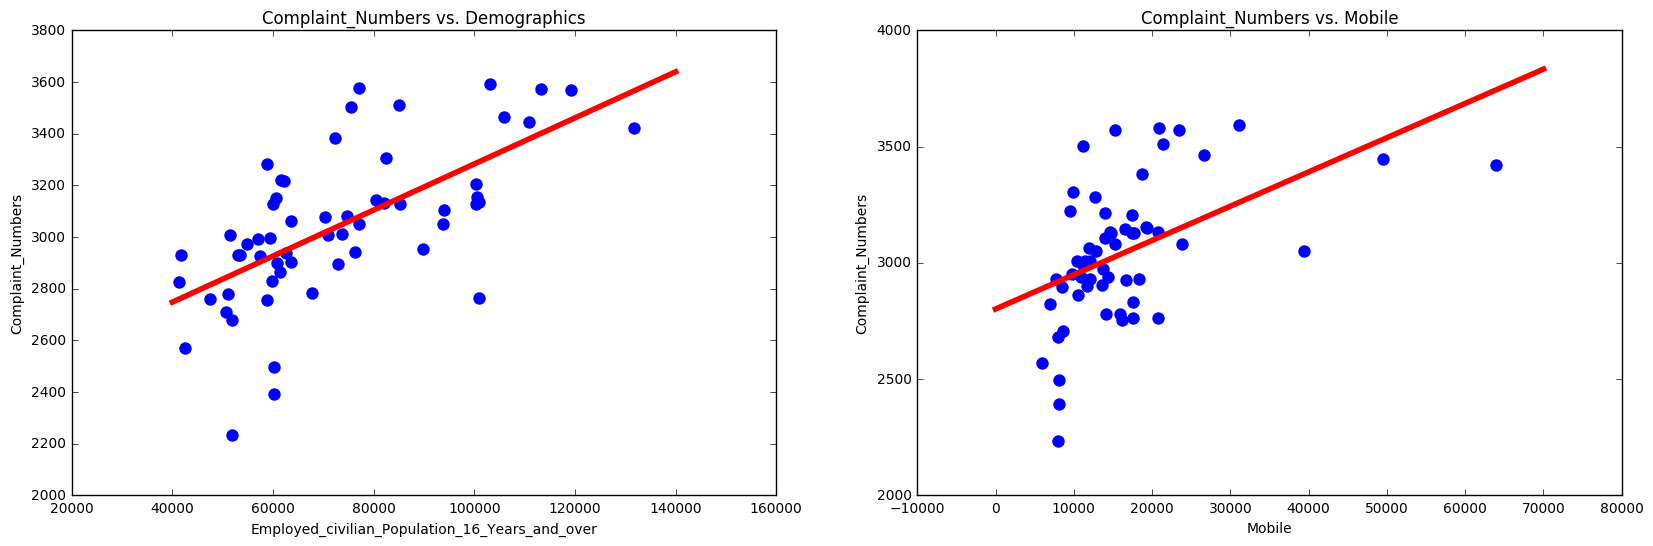

In [270]:
fig = plt.figure(figsize = (20,6))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
ax1.set_xlabel('Employed_civilian_Population_16_Years_and_over')
ax1.set_ylabel('Complaint_Numbers')
ax1.set_title('Complaint_Numbers vs. Demographics')
ax2.set_xlabel('Mobile')
ax2.set_ylabel('Complaint_Numbers')
ax2.set_title('Complaint_Numbers vs. Mobile')

ax1.scatter(Final.iloc[:,2], Final.iloc[:,1], lw=0, s=80)
ax2.scatter(Final.iloc[:,3], Final.iloc[:,1], lw=0, s=80)

res1 = smf.ols('Complaint_Numbers ~ Employed_civilian_Population_16_Years_and_over', data=Final).fit()
res2 = smf.ols('Complaint_Numbers ~ Mobile', data=Final).fit()
def line(a, b, x):
    return a*x +b

x1space = np.linspace(40000,140000,10)
ax1.plot(x1space, line(res1.params[1], res1.params[0], x1space), 'r', lw=4)
x2space = np.linspace(0,70000,10)
ax2.plot(x2space, line(res2.params[1], res2.params[0], x2space), 'r', lw=4)

plt.show()